# This tutorial shows the transfer learning of pre-trained ImageNet models using dog and cat images

### 1. We first extract pre-trained features from the ResNet50 model
### 2. We then visualize these features using the t-SNE view
### 3. We train a traditional SVM classifier to classify these features

In [1]:
# First load related packages
import torch
import torch.nn as nn
from torchvision import models
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from sklearn.manifold import TSNE
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

**Load model and prepare the dataset to read images**

In [2]:
# Load pre-trained ResNet50 model
model = models.resnet50(pretrained=True)
# Extract features from the last fc layer, the output features size should be equal to 2048
model_extract = nn.Sequential(*list(model.children())[:-1])

# transfer images to tensor and normalize the image 
transfrom = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224, 224)),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

# Add image folder path
image_path = './Dog_cat'
dataset=ImageFolder(image_path,transform=transfrom)

# Read all images to dataLoader, batch size can be bigger
train_loader=DataLoader(dataset, batch_size=1,shuffle=False)


**Step 1: Extract features from a pre-trained ResNet50 model**

In [3]:
# Feature extraction 
num =0
features = []
labels   = []

with torch.no_grad():
    for x, y in iter(train_loader):
        feature = model_extract(x)
        features.append(feature)
        labels.append(y)
        # check x, y and num    
#         print(x.shape)
#         print(y) 
#         print(num)
#         num = num + 1
#     print(num)

features = torch.squeeze(torch.cat(features))
labels   = torch.cat(labels)

print(features.shape)
print(labels.shape)

torch.Size([60, 2048])
torch.Size([60])


**Step 2: visualize extracted features using the t-SNE view**

c:\users\yz945\appdata\local\programs\python\python37\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
c:\users\yz945\appdata\local\programs\python\python37\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 59 nearest neighbors...
[t-SNE] Indexed 60 samples in 0.000s...
[t-SNE] Computed neighbors for 60 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 60 / 60
[t-SNE] Mean sigma: 0.446239
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.123455
[t-SNE] KL divergence after 1000 iterations: 0.520891


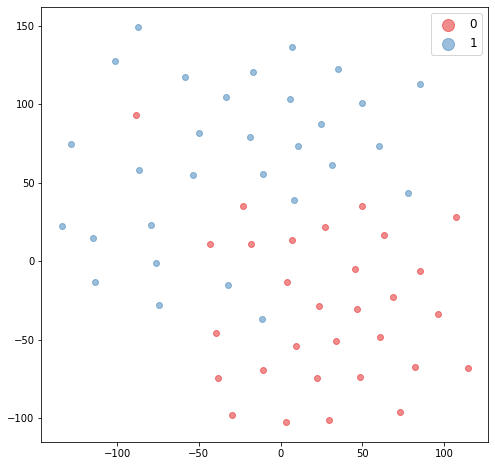

In [4]:
# Create a two dimensional t-SNE projection of the embeddings
tsne = TSNE(2, verbose=1)
tsne_proj = tsne.fit_transform(features)
# Check the number of categories
num_categories = torch.unique(labels).shape[0] #0: cat; 1: dog

# Plot those points as a scatter plot and label them based on the true labels
cmap = cm.get_cmap('Set1')
fig, ax = plt.subplots(figsize=(8,8))


for lab in range(num_categories):
    indices = labels==lab
    ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], c=np.array(cmap(lab)).reshape(1,4), label = lab ,alpha=0.5)
ax.legend(fontsize='large', markerscale=2)
plt.show()

**Step 3: We train a traditional SVM classifier using to classify these features**

In [5]:
# Since we only have 60 samples, we use five-fold cross-validation to calculate the accuracy of SVM
k_folds = 5
# Set svm classifer
clf = svm.SVC(kernel='linear') # Linear Kernel
# clf = KNeighborsClassifier(n_neighbors=3) 3-nn classifer 
cvs=cross_val_score(clf,features,labels,scoring='accuracy',cv=k_folds)
print('cross_val_accuray=  ',cvs.mean()*100)
y_pred=cross_val_predict(clf,features,labels,cv=k_folds)
conf_mat=confusion_matrix(y_pred,labels)
print('Confusion matrix is: ')
print(conf_mat)
print('All accuracies are: ')
print(conf_mat/np.sum(conf_mat))

cross_val_accuray=   86.66666666666669
Confusion matrix is: 
[[27  5]
 [ 3 25]]
All accuracies are: 
[[0.45       0.08333333]
 [0.05       0.41666667]]


In [6]:
# Or one simple split
train_x = features[::2,:] # take tensor every 2 steps
train_y = labels[::2]
test_x = features[1::2,:]
test_y = labels[1::2]   

clf.fit(train_x, train_y)
fin_val = clf.predict(test_x)
print(np.sum(fin_val==np.array(test_y))/test_y.shape[0])

0.8666666666666667
